In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
from statsmodels.datasets import grunfeld
from linearmodels.panel  import PanelOLS
import pandas as pd
import build_data_functions as bdf
import plot_data_functions as pdf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import model_functions as mf
import plot_model_functions as pmf
import panelOLS_models 
import spatial_error_model as sem
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import pycountry
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from scipy.stats import normaltest

In [2]:
years = list(range(2005, 2017))

In [3]:
y = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/resident_foreigners_norm.csv", sep = "\t", index_col=0)
y = y.groupby(["Province", "Country", "Year"], as_index=False)["Value"].sum()
y = bdf.pivot(y, "Country", "Value")

resident_foreigners_norm = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/resident_foreigners_norm.csv")

#unesco_demo = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/countries_info.csv", sep = "\t", index_col=[0,1])

## Italian Stock Prediction

In [4]:
# To get the Italy info we need to sum the 5 Italian zones
zones = list(pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"]).index.levels[0])

for t in y.index.levels[1]:
    y.loc[("Italia", t), :] = y.loc[(zones, t), :].sum()

In [5]:
temp = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"])
xs = pd.DataFrame(columns=["Province", "Year"]+temp.columns.tolist())
xs = xs.set_index(["Province","Year"])

for t in temp.index.levels[1]:
    xs.loc[("Italia", t), :] = temp.loc[(zones, t), :].sum()

In [6]:
palette = ['blue', 'darkgreen', 'yellowgreen', 'orange', 'lightcoral', 'red', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'fuchsia']

In [7]:
countries_list = ["Romania", "Morocco", "Albania", "Tunisia", "Egypt", "Ecuador", "Peru", "China", "Philippines"]
countries_list_iso3 = [pycountry.countries.get(name=country).alpha_3 for country in countries_list]
target = "Italia"
# number of features to select
ks = [3, 5, 7, 10, 15]

In [8]:
y_hat = mf.compute_regression_model(y, xs, years, countries_list, target, ks)

ROU
['y_prev_1', 'native population - Total', 'Average age of mothers at birth', 'Disposable Income', 'Free activities in voluntary associations']
MAR
['y_prev_1', 'Disposable Income', 'y_prev_2', 'native population - Total', 'Free activities in voluntary associations', 'Average age of mothers at birth', 'Average age of fathers at birth', 'political_info - Some times in a week', 'Average monthly expenditure for housing', 'unemployment - Total', 'internal_migration - Foreign country', 'political_info - A time per week', 'internal_migration - Italy', 'reach_difficulty - Pharmacy', 'Furniture, articles and services for the house']
ALB
['y_prev_1', 'Disposable Income', 'y_prev_2', 'native population - Total', 'Average age of mothers at birth', 'Free activities in voluntary associations', 'Average age of fathers at birth', 'political_info - Some times in a week', 'Average monthly expenditure for housing', 'internal_migration - Italy', 'internal_migration - Foreign country', 'Communications'

In [9]:
pdf.relation_plot_time_variant_intern_function(y_hat, countries_list_iso3, years, ["Predicted"], resident_foreigners_norm.groupby(["Country", "Year"]), plt.figure(1, figsize=(15,14)), 331, 45, palette, None, "Immigrant Stock Real VS Predicted", True, "Plots/regression_model_italy", False)

In [10]:
y_italia_pred = y.copy()
for country in countries_list_iso3:
    y_italia_pred.loc[("Italia", years), country] = np.array(y_hat.loc[(slice(None), country), "Predicted"].values, dtype=np.float32)

## Zones Prediction - H. Jayet et al. paper

In [11]:
xs_zones = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"])
xs_zones = pd.concat([xs_zones, xs])
zones_data = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/territori.csv")
zones_data = zones_data.replace(['Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento'], ['Bolzano / Bozen', 'Trento'])

In [12]:
# Distance matrix related to the interested locations (regions capitals)
temp_W = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/Zones_distances_matrix_mean.csv", sep = "\t", index_col=0)

In [13]:
# Add Italy distance info as mean of the five zones
temp_W["Italia"] = [temp_W.loc[z].mean() for z in temp_W.index]
temp_W.loc["Italia"] = [temp_W.loc[z].mean() for z in temp_W.index] + [0]

In [14]:
temp_W = (1/temp_W)**2
# w_ij = 0 if i=j
temp_W[temp_W == np.inf] = 0
# row standardization: every arow sum up to 1
temp_W = temp_W.div(temp_W.sum(axis=1), axis=0)
# Just to make sure the matrix has the right sort
temp_W = temp_W.sort_index(axis=1)
temp_W = temp_W.sort_index(axis=0)

In [15]:
#palette = sns.color_palette()
palette = ['blue', 'darkgreen', 'yellowgreen', 'orange', 'lightcoral', 'red', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'fuchsia']

### Romania

In [16]:
vars_ = [["Free activities in voluntary associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Post offices", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

---------- Step I ----------
Current time: 10:44:42
Optimization terminated successfully.
Current time: 10:46:45
Computational time: 0:02:02.678880
---------- Step II ----------
---------- Validation ----------


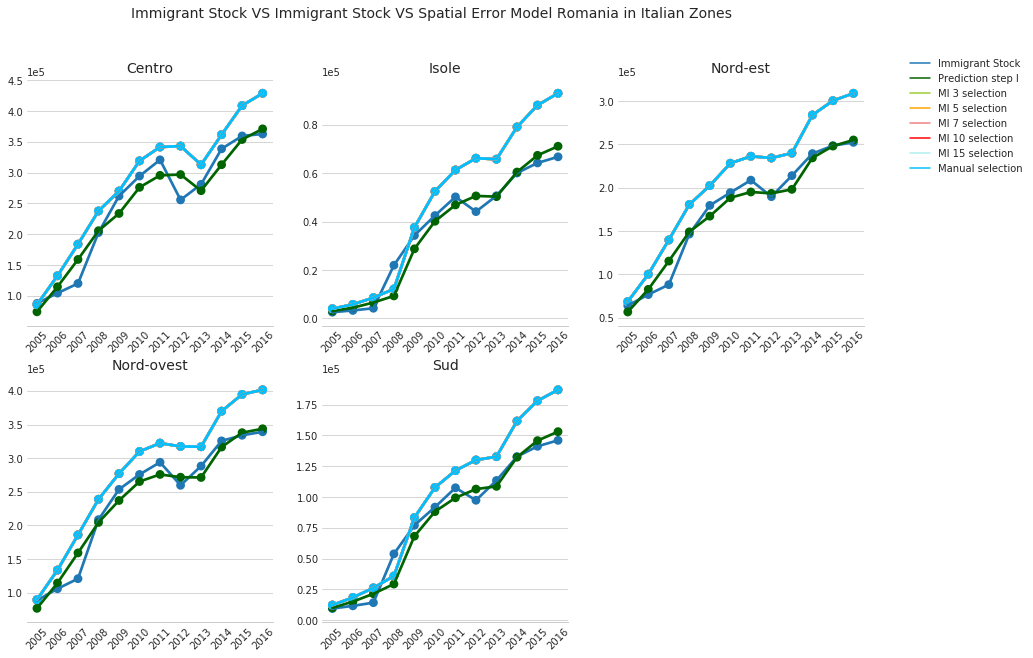

R-squared for Prediction step I 0.983000.
R-squared for MI 3 selection 0.899000.
R-squared for MI 5 selection 0.899000.
R-squared for MI 7 selection 0.899000.
R-squared for MI 10 selection 0.899000.
R-squared for MI 15 selection 0.899000.
R-squared for Manual selection 0.899000.


In [17]:
res_pred, res_params = sem.run_model(y, "Romania", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

---------- Step I ----------
Current time: 10:47:53
Optimization terminated successfully.
Current time: 10:49:48
Computational time: 0:01:55.078136
---------- Step II ----------
---------- Validation ----------


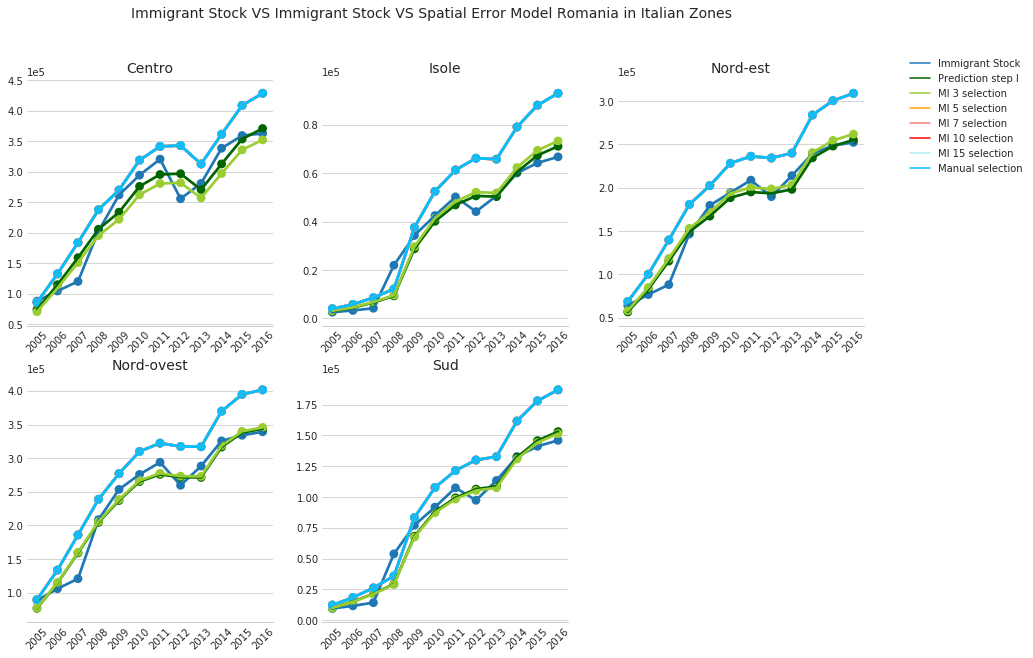

R-squared for Prediction step I 0.983000.
R-squared for MI 3 selection 0.979000.
R-squared for MI 5 selection 0.899000.
R-squared for MI 7 selection 0.899000.
R-squared for MI 10 selection 0.899000.
R-squared for MI 15 selection 0.899000.
R-squared for Manual selection 0.899000.


In [19]:
res_pred, res_params = sem.run_model(y, "Romania", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Morocco

In [21]:
vars_ = [["Free activities in voluntary associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Post offices", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

---------- Step I ----------
Current time: 10:58:45
Desired error not necessarily achieved due to precision loss.
Current time: 11:08:55
Computational time: 0:10:09.657256
---------- Step II ----------
---------- Validation ----------


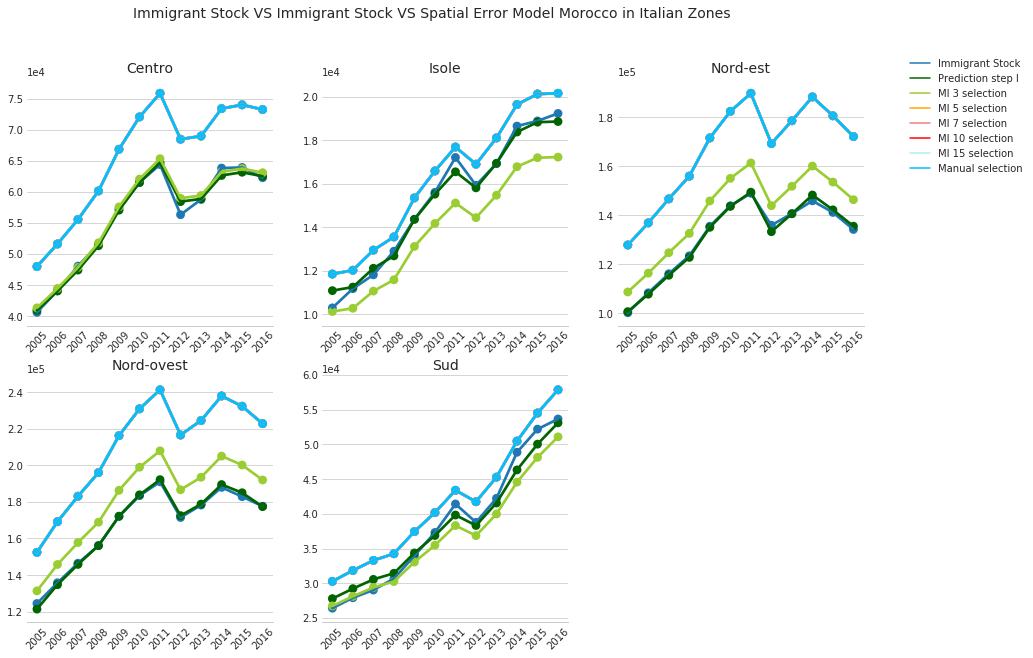

R-squared for Prediction step I 1.000000.
R-squared for MI 3 selection 0.981000.
R-squared for MI 5 selection 0.813000.
R-squared for MI 7 selection 0.813000.
R-squared for MI 10 selection 0.813000.
R-squared for MI 15 selection 0.813000.
R-squared for Manual selection 0.813000.


In [22]:
res_pred, res_params = sem.run_model(y, "Morocco", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

---------- Step I ----------
Current time: 11:09:24
Desired error not necessarily achieved due to precision loss.
Current time: 11:17:25
Computational time: 0:08:01.005359
---------- Step II ----------
---------- Validation ----------


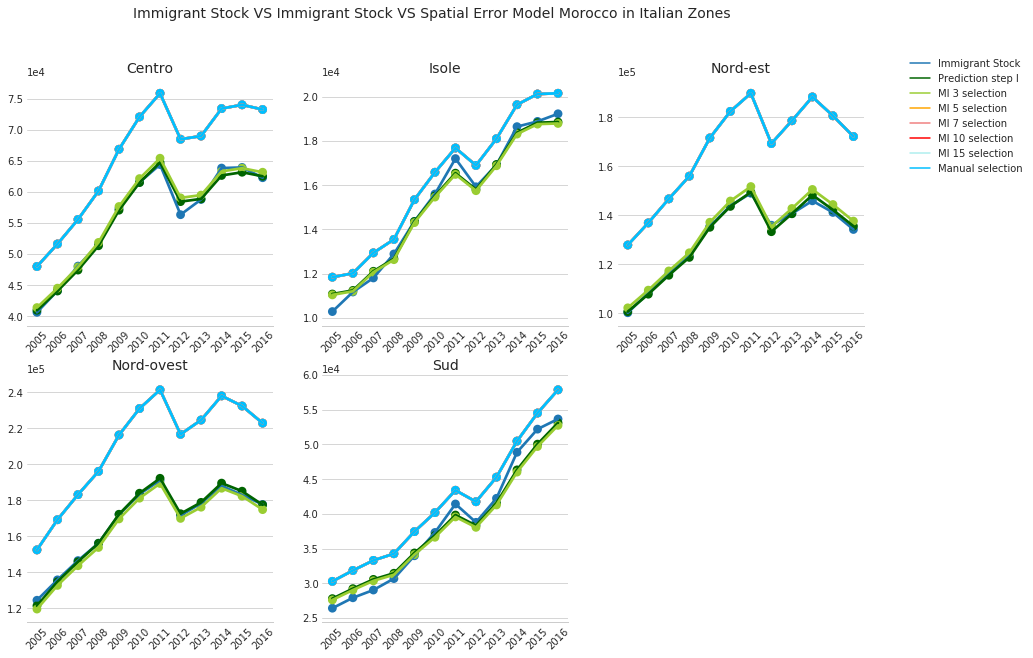

R-squared for Prediction step I 1.000000.
R-squared for MI 3 selection 0.999000.
R-squared for MI 5 selection 0.813000.
R-squared for MI 7 selection 0.813000.
R-squared for MI 10 selection 0.813000.
R-squared for MI 15 selection 0.813000.
R-squared for Manual selection 0.813000.


In [23]:
res_pred, res_params = sem.run_model(y, "Morocco", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Albania

In [24]:
vars_ = [["native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Disposable Income", 
  "political_info - Every day"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Born alive", "Disposable Income", 
  "political_info - Every day", "reach_difficulty - Supermarket"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "political_info - Never", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Pharmacy", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

---------- Step I ----------
Current time: 11:17:33
Optimization terminated successfully.
Current time: 11:25:45
Computational time: 0:08:12.495374
---------- Step II ----------
---------- Validation ----------


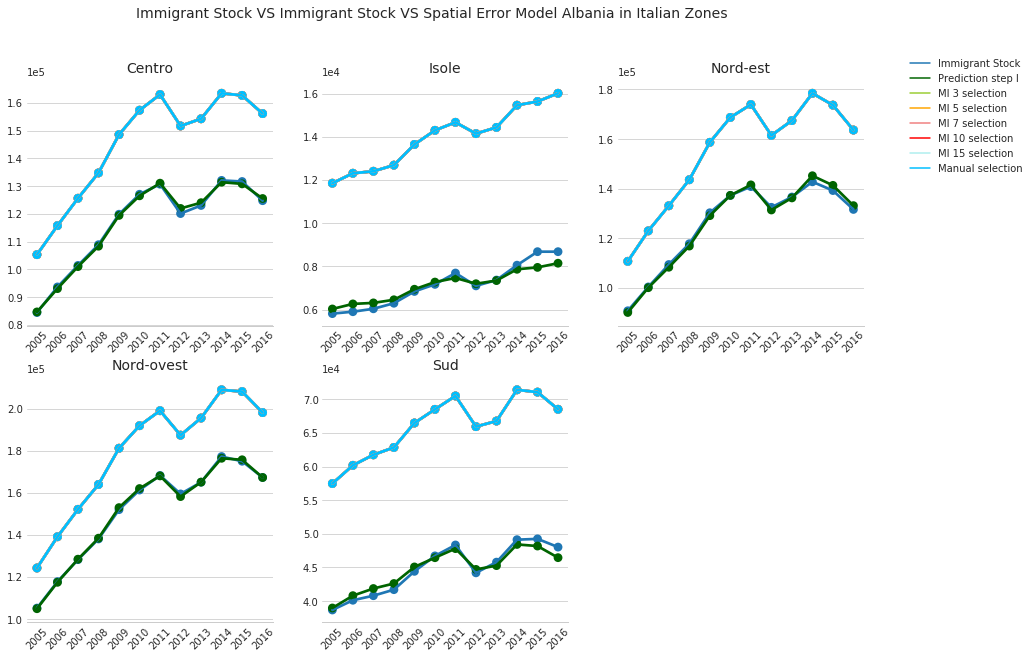

R-squared for Prediction step I 1.000000.
R-squared for MI 3 selection 0.810000.
R-squared for MI 5 selection 0.810000.
R-squared for MI 7 selection 0.810000.
R-squared for MI 10 selection 0.810000.
R-squared for MI 15 selection 0.810000.
R-squared for Manual selection 0.810000.


In [25]:
res_pred, res_params = sem.run_model(y, "Albania", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

---------- Step I ----------
Current time: 11:25:53
Optimization terminated successfully.
Current time: 11:34:15
Computational time: 0:08:22.246298
---------- Step II ----------
---------- Validation ----------


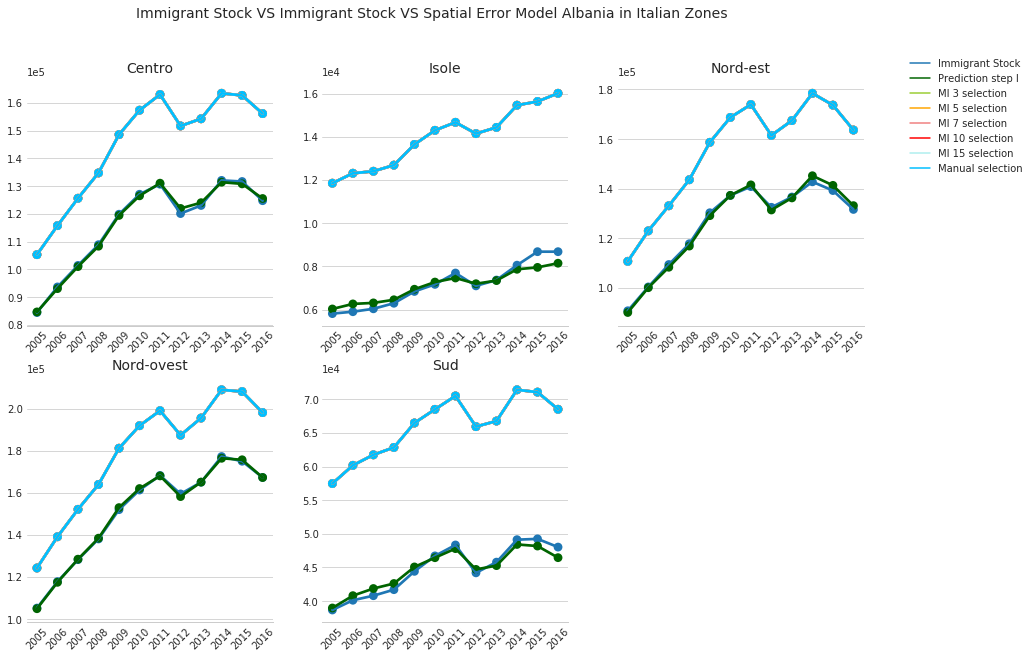

R-squared for Prediction step I 1.000000.
R-squared for MI 3 selection 0.810000.
R-squared for MI 5 selection 0.810000.
R-squared for MI 7 selection 0.810000.
R-squared for MI 10 selection 0.810000.
R-squared for MI 15 selection 0.810000.
R-squared for Manual selection 0.810000.


In [26]:
res_pred, res_params = sem.run_model(y, "Albania", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Tunisia

In [27]:
vars_ = [["Pay money to an association"], 
 ["Pay money to an association", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "political_info - Never", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Never", "Pay money to an association", "reach_difficulty - Pharmacy", 
  "reach_difficulty - Post offices", "Born alive", "Accommodation and catering services", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

---------- Step I ----------
Current time: 11:38:03
Optimization terminated successfully.
Current time: 11:43:42
Computational time: 0:05:38.322760
---------- Step II ----------
---------- Validation ----------


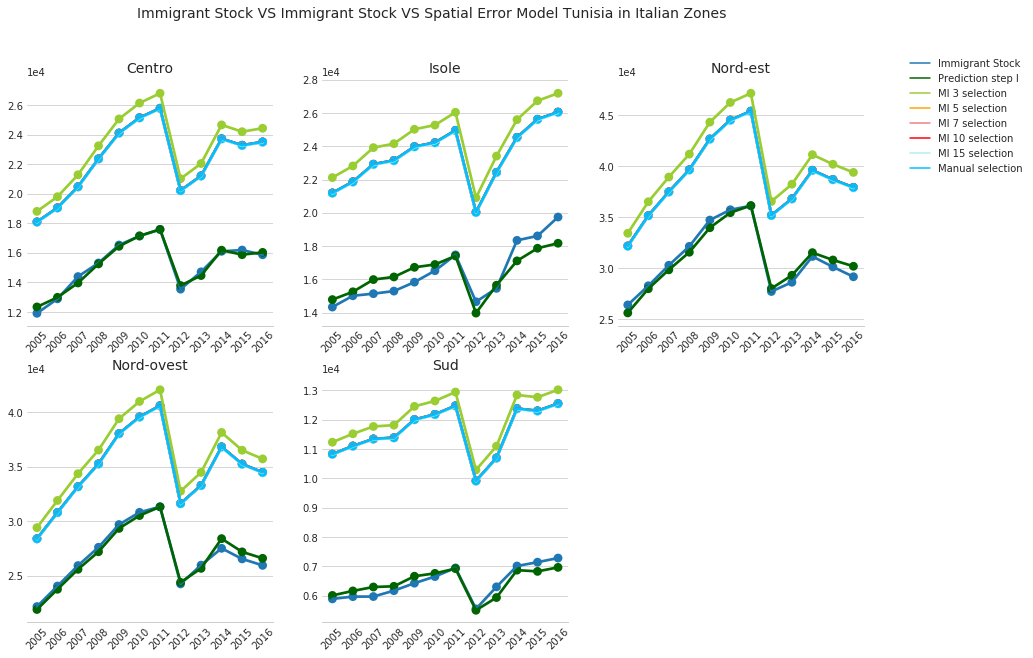

R-squared for Prediction step I 0.997000.
R-squared for MI 3 selection 0.166000.
R-squared for MI 5 selection 0.368000.
R-squared for MI 7 selection 0.368000.
R-squared for MI 10 selection 0.368000.
R-squared for MI 15 selection 0.375000.
R-squared for Manual selection 0.367000.


In [28]:
res_pred, res_params = sem.run_model(y, "Tunisia", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "Tunisia", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

---------- Step I ----------
Current time: 11:49:02


### Egypt

In [ ]:
vars_ = [["native population - Total"], 
 ["Pay money to an association", "Non food", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Non food"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Other goods and services", "Pay money to an association", "Communications", 
  "reach_difficulty - Post offices", "Food and non-alcoholic beverages", 
  "Accommodation and catering services", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = sem.run_model(y, "Egypt", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "Egypt", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Ecuador

In [ ]:
vars_ = [["native population - Total"], 
 ["Pay money to an association", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "reach_difficulty - Post offices"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Accommodation and catering services", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Other goods and services", "Pay money to an association", "Disposable Income", 
  "reach_difficulty - Post offices", "reach_difficulty - Supermarket", 
  "Accommodation and catering services", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = sem.run_model(y, "Ecuador", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "Ecuador", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Peru

In [ ]:
vars_ = [["native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Pay money to an association", 
  "Disposable Income"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Disposable Income", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Post offices", 
  "internal_migration - Italy", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Non food", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "Disposable Income", "Pay money to an association", "Born alive", 
  "reach_difficulty - Post offices", "reach_difficulty - Supermarket", 
  "Free activities in non voluntary associations", "Transport"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "political_info - Every day", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = sem.run_model(y, "Peru", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "Peru", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### China

In [ ]:
vars_ = [["Born alive"], 
 ["Born alive", "internal_migration - Foreign country", 
  "political_info - Some times in a week"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "Born alive", "political_info - Some times in a week", 
  "reach_difficulty - Pharmacy"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "reach_difficulty - Post offices", "Born alive", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Pharmacy", 
  "political_info - Some times in a week", "political_info - Every day"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "reach_difficulty - Post offices", "Born alive", 
  "Meetings in cultural, recreational or other associations", "reach_difficulty - Pharmacy", 
  "political_info - Some times in a week", "political_info - Every day", "native population - Total", 
  "reach_difficulty - Emergency room", "Disposable Income", "Pay money to an association", 
  "Average age of fathers at birth"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = sem.run_model(y, "China", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "China", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

### Philippines

In [ ]:
vars_ = [["native population - Total"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food", "Housing, water, electricity, gas and other fuels", "Accommodation and catering services", 
  "Free activities in voluntary associations"], 
 ["Other goods and services", "internal_migration - Foreign country", 
  "native population - Total", "Communications", 
  "Non food", "Housing, water, electricity, gas and other fuels", "Accommodation and catering services", 
  "Free activities in voluntary associations", "reach_difficulty - Post offices" "Born alive", 
  "Food and non-alcoholic beverages", "Pay money to an association", "Average age of fathers at birth"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = sem.run_model(y, "Philippines", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, False, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)

In [ ]:
res_pred, res_params = sem.run_model(y, "Philippines", years, "Italia", xs_zones, temp_W, temp_W.columns.tolist(), vars_, True, palette, "Spatial Error Model", save = False, data_hat = y_italia_pred)